<a href="https://colab.research.google.com/github/michellemtf/NeuromatchProject/blob/main/Allen_Familiar_vs_Novel_cyl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
The following notebook demonstrates how to load neural data for experiments in the same plane, but in different sessions (`same container`), to compare neural activity during familiar vs novel conditions. 

# Set up environment and import packages

We have built a package called `mindscope_utilities` which contains some useful convenience functions. The `allenSDK` is a dependency of this package and will be automatically installed when you install `mindscope_utilities` per the instrutions below.

We will first install `mindscope_utilities` into our colab environment by running the commands below. When this cell is complete, click on the `RESTART RUNTIME` button that appears at the end of the output. Note that running this cell will produce a long list of outputs and some error messages. Clicking `RESTART RUNTIME` at the end will resolve these issues. 

You can minimize the cell after you are done to hide the output. 

#### Install necessary packages

In [1]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

#### Next we will import packages we need later in the notebook

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

# Load the session and experiment summary tables

The AllenSDK provides functionality for downloading tables that describe all sessions and experiments (individual imaging planes) in the Visual Behavior 2P dataset. We first download the data cache:

In [3]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

The data manifest is comprised of three types of tables: 

1. `behavior_session_table` 
2. `ophys_session_table` 
3. `ophys_experiment_table` 

---

The `behavior_session_table` contains metadata for every behavior session in the dataset. **Some behavior sessions have 2-photon data associated with them, while others took place during training in the behavior facility**. The different training stages that mice are progressed through are described by the session_type.

---

The `ophys_session_table` contains **metadata for every 2-photon imaging** (aka optical physiology, or ophys) **session in the dataset, associated with a unique ophys_session_id**. An ophys session is one continuous recording session under the microscope, and can contain different numbers of imaging planes (aka experiments) depending on which microscope was used. 
- For Scientifica sessions, there will only be one experiment (aka imaging plane) per session. 
- For Multiscope sessions, there can be up to eight imaging planes per session. 

Quality Control (QC) is performed on each individual imaging plane within a session, so each can fail QC independent of the others. This means that a Multiscope session may not have exactly eight experiments (imaging planes).

---

The `ophys_experiment_table` contains **metadata for every ophys experiment in the dataset, which corresponds to a single imaging plane recorded in a single session, and associated with a unique ophys_experiment_id**. 

A key part of our experimental design is targeting a given population of neurons, contained in one imaging plane, across multiple session_types (further described below) to examine the impact of varying sensory and behavioral conditions on single cell responses. The collection of all imaging sessions for a given imaging plane is referred to as an ophys container, associated with a unique ophys_container_id. Each ophys container may contain different numbers of sessions, depending on which experiments passed QC, and how many retakes occured (when a given session_type fails QC on the first try, an attempt is made to re-acquire the session_type on a different recording day - this is called a retake, also described further below)

---

<div>
<img src="https://allensdk.readthedocs.io/en/latest/_static/visual_behavior_2p/data_structure.png", width="1000"/>
</div>

# Load summary tables

Then we can access the session and experiment tables directly.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane. 

In [4]:
behavior_session_table = cache.get_behavior_session_table()
ophys_session_table    = cache.get_ophys_session_table()
ophys_experiment_table = cache.get_ophys_experiment_table()
#ophys_experiment_table.head()
#ophys_experiment_table['mouse_id']

During the 2-photon imaging portion of the experiment, **mice perform the task with the same set of images they saw during training (either image set A or B), as well as an additional novel set of images (whichever of A or B that they did not see during training)**. This allows evaluation of the impact of different sensory contexts on neural activity - familiarity versus novelty. 

- Sessions with `familiar` images include those starting with `OPHYS_0, OPHYS_1, OPHYS_2, and OPHYS_3`. 
- Sessions with `novel` images include those starting with `OPHYS_4, OPHYS_5, and OPHYS_6`.

Interleaved between active behavior sessions are `passive` viewing sessions where mice are given their daily water ahead of the sesssion (and are thus satiated) and view the stimulus with the lick spout retracted so they are unable to earn water rewards. This allows comparison of neural activity in response to stimuli under different behavioral context - **active task engagement and passive viewing without reward**. 

- `Passive sessions` include `OPHYS_2_images_A_passive` (passive session with familiar images), and `OPHYS_5_images_A_passive` (passive session with novel images).

In [5]:
# Dictionary with session types
#we will pick 'OPHYS_2_images_A_passive' and 'OPHYS_5_images_A_passive' - cyl
session_type = {'familiar_active': ['OPHYS_0', 'OPHYS_1', 'OPHYS_2', 'OPHYS_3'],
                'novel_active':    ['OPHYS_4', 'OPHYS_5', 'OPHYS_6'],
                'familiar_pasive': ['OPHYS_2_images_A_passive'],
                'novel_pasive':    ['OPHYS_5_images_A_passive','OPHYS_5_images_B_passive']} # note: I think "OPHYS_5_images_B_passive" is novel, but not sure

cre_line_type = ['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre']

print(f'*Ophys session types in the current dataset:*\n\n {ophys_session_table.session_type.unique()}',)             

*Ophys session types in the current dataset:*

 ['OPHYS_1_images_A' 'OPHYS_2_images_A_passive' 'OPHYS_3_images_A'
 'OPHYS_4_images_B' 'OPHYS_5_images_B_passive' 'OPHYS_6_images_B'
 'OPHYS_1_images_B' 'OPHYS_2_images_B_passive' 'OPHYS_3_images_B'
 'OPHYS_4_images_A' 'OPHYS_6_images_A' 'OPHYS_5_images_A_passive']


# Load two example experiments (planes) to compare familiar vs novel responses

#### Add two columns to "ophys_experiment_table" to identify if individual experiments are:
- Active or passive 
- Familiar or novel

In [6]:
# Active vs passive
ind_passive = (ophys_experiment_table.session_type.str.contains(session_type['familiar_pasive'][0]) |
               ophys_experiment_table.session_type.str.contains(session_type['novel_pasive'][0])    |
               ophys_experiment_table.session_type.str.contains(session_type['novel_pasive'][1]))
ind_passive[ind_passive==False] = 'active'
ind_passive[ind_passive==True]  = 'pasive'
ophys_experiment_table['behavior_condition'] = ind_passive

# Familiar vs novel
fam = session_type['familiar_active'] + session_type['familiar_pasive']

i_fam = pd.Series([False]*ophys_experiment_table.shape[0])
for f in fam:
  i_fam = (i_fam | ophys_experiment_table.session_type.str.contains(f))
i_fam[i_fam==True]  = 'familiar'
i_fam[i_fam==False] = 'novel'  
ophys_experiment_table['experimental_condition'] = i_fam

In [7]:
ophys_experiment_table.experimental_condition.unique()

array(['familiar', 'novel'], dtype=object)

#### Find a container with familiar and novel sessions

In [8]:
# Containers
i_fam = ophys_experiment_table.query('cre_line == "Vip-IRES-Cre" and behavior_condition == "active" and experimental_condition == "familiar"')['ophys_container_id']
i_nov = ophys_experiment_table.query('cre_line == "Vip-IRES-Cre" and behavior_condition == "active" and experimental_condition == "novel"')['ophys_container_id']

# Which containers are in both conditions
unic_fam = i_fam.unique()
i_both = []
for i,row in enumerate(unic_fam):
  if (row == i_nov.values).any():
    i_both.append(i)
    
# Choose the first container with fam & nov conditions
id_contain = unic_fam[i_both[0]]

In [8]:
# Containers-cyllllll
i_fam = ophys_experiment_table.query('cre_line == "Vip-IRES-Cre" and behavior_condition == "pasive" and experimental_condition == "familiar"')['ophys_container_id']
i_nov = ophys_experiment_table.query('cre_line == "Vip-IRES-Cre" and behavior_condition == "pasive" and experimental_condition == "novel"')['ophys_container_id']

# Which containers are in both conditions
unic_fam = i_fam.unique()
i_both = []
for i,row in enumerate(unic_fam):
  if (row == i_nov.values).any():
    i_both.append(i)
    
# Choose the first container with fam & nov conditions
id_contain = unic_fam[i_both[0]]

In [9]:
id_contain

791352433

In [10]:
print(i_both)

[0, 1, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 50, 51, 52, 53, 54, 55, 56]


#### Select the experiments of a specific container

In [ ]:
 exper_famil = ophys_experiment_table.query('cre_line == "Vip-IRES-Cre" and behavior_condition == "pasive" and experimental_condition == "familiar" and ophys_container_id == @id_contain')
 exper_novel = ophys_experiment_table.query('cre_line == "Vip-IRES-Cre" and behavior_condition == "pasive" and experimental_condition == "novel" and ophys_container_id == @id_contain')

 exper_famil.head()
 exper_novel.head()

# Load one example session
We are going to select two sessions with the same plane, but recorded in differnt sessions

In [49]:
# Ophys experimental ID (choose the first experiment of familiar and novel conditions)
ophys_experiment_id_fam = exper_famil.index[0]
ophys_experiment_id_nov = exper_novel.index[0]

# Download particular ophys experiments
fam_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id_fam)
nov_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id_nov)

behavior_ophys_experiment_798404219.nwb: 100%|██████████| 380M/380M [00:14<00:00, 25.5MMB/s]
behavior_ophys_experiment_796108483.nwb: 100%|██████████| 389M/389M [00:14<00:00, 27.6MMB/s]


### Structure the data 

In [50]:
metadata_keys = [
    'ophys_experiment_id',
    'ophys_session_id',
    'targeted_structure',
    'imaging_depth',
    'equipment_name',
    'cre_line',
    'mouse_id',
    'sex',
]

In [ ]:
fam_experiment_neural_data = ophys.build_tidy_cell_df(fam_experiment)
nov_experiment_neural_data = ophys.build_tidy_cell_df(nov_experiment)

for metadata_key in metadata_keys:
  fam_experiment_neural_data[metadata_key] = fam_experiment.metadata[metadata_key]
  nov_experiment_neural_data[metadata_key] = nov_experiment.metadata[metadata_key]

fam_experiment_neural_data.head()
# nov_experiment_neural_data.head()

# Examine Cell IDs
We can get the unique Cell IDs in our dataset as follows:

In [52]:
cell_ids = fam_experiment_neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

# Choose only one neuron ID
cell_id = cell_ids[0]

there are 39 unique cells
cell ids are: [1086492088, 1086493365, 1086491165, 1086491118, 1086491059, ..., 1086491597, 1086492499, 1086492406, 1086491530, 1086490719]
Length: 39
Categories (39, int64): [1086492088, 1086493365, 1086491165, 1086491118, ..., 1086492499, 1086492406,
                         1086491530, 1086490719]


In [54]:
#cyllllll
cell_ids_fam = fam_experiment_neural_data['cell_specimen_id'].unique()
print('there are {} unique cells for fam'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

cell_ids_nov = nov_experiment_neural_data['cell_specimen_id'].unique()
print('there are {} unique cells for nov'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

# Choose only one neuron ID
cell_id_fam = cell_ids_fam[0:10]
cell_id_nov = cell_ids_nov[0:10]

there are 39 unique cells for fam
cell ids are: [1086492088, 1086493365, 1086491165, 1086491118, 1086491059, ..., 1086491597, 1086492499, 1086492406, 1086491530, 1086490719]
Length: 39
Categories (39, int64): [1086492088, 1086493365, 1086491165, 1086491118, ..., 1086492499, 1086492406,
                         1086491530, 1086490719]
there are 39 unique cells for nov
cell ids are: [1086492088, 1086493365, 1086491165, 1086491118, 1086491059, ..., 1086491597, 1086492499, 1086492406, 1086491530, 1086490719]
Length: 39
Categories (39, int64): [1086492088, 1086493365, 1086491165, 1086491118, ..., 1086492499, 1086492406,
                         1086491530, 1086490719]


In [56]:
#cylllll
#cell_id_fam
cell_id_nov

[1086491347, 1086491308, 1086491118, 1086491195, 1086491165, 1086491083, 1086490897, 1086491006, 1086490644, 1086492307]
Categories (44, int64): [1086491347, 1086491308, 1086491118, 1086491195, ..., 1086492406, 1086491530,
                         1086492221, 1086490480]

If we wanted to get the timeseries for one cell, we could query the `neural_data` dataframe. 

In [ ]:
fam_single_cell_timeseries = fam_experiment_neural_data.query('cell_specimen_id == @cell_id')
nov_single_cell_timeseries = nov_experiment_neural_data.query('cell_specimen_id == @cell_id')
fam_single_cell_timeseries.head(5)
# nov_single_cell_timeseries.head(5)

In [63]:
#cyllll
for cell_id in cell_id_fam:
    fam_single_cell_timeseries = fam_experiment_neural_data.query('cell_specimen_id == @cell_id')
    nov_single_cell_timeseries = nov_experiment_neural_data.query('cell_specimen_id == @cell_id')


Each cell has three types of traces:
- `dff` column is the Calcium fluorescence signal, normalized to background fluorescence.
- `events` column is deconvolved events from dff trace, which approximates neural firing rate and removes the slow decay of the Calcium signal (for more details, you can read EVENT DETECTION section in [Visual Behavior whitepaper](https://portal.brain-map.org/explore/circuits/visual-behavior-2p)).
- `filtered_events` column is events smoothed with a half-gaussian kernel. 

We can then plot DeltaF/F for this cell for the full experiment as follows:

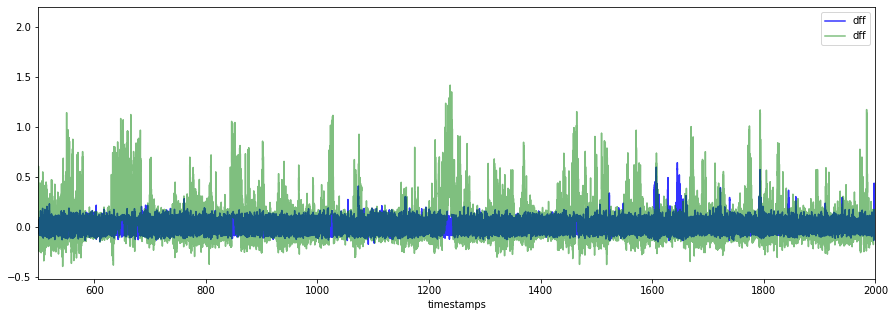

In [17]:
fig, ax = plt.subplots(figsize=(15,5))

fam_single_cell_timeseries.plot(
    x = 'timestamps',
    y = ['dff'],
    ax = ax,
    color='blue',
    alpha = 0.8
)

nov_single_cell_timeseries.plot(
    x = 'timestamps',
    y = ['dff'],
    ax = ax,
    color='green',
    alpha = 0.5
)

ax.axes.axes.set_xlim(500,2000);

# Load stimulus data into memory

In [18]:
fam_stimulus_table = fam_experiment.stimulus_presentations
nov_stimulus_table = nov_experiment.stimulus_presentations

fam_stimulus_table.head(10)
# nov_stimulus_table.head(10)

,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,,
0,0.25024,18000.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,0,False,17985,306.84438,307.09462,False
1,0.25021,18045.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,1,False,18030,307.59503,307.84524,False
2,0.25023,18090.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,2,False,18075,308.34564,308.59587,False
3,0.25028,18135.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,3,False,18120,309.09622,309.34650,False
4,0.25018,18180.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4,False,18165,309.84689,310.09707,False
5,0.25018,18225.0,6,im085,Natural_Images_Lum_Matched_set_training_2017.0...,5,False,18210,310.59751,310.84769,True
6,0.25026,18270.0,6,im085,Natural_Images_Lum_Matched_set_training_2017.0...,6,False,18255,311.34811,311.59837,False
7,0.25021,18315.0,6,im085,Natural_Images_Lum_Matched_set_training_2017.0...,7,False,18300,312.09867,312.34888,False
8,0.25023,18360.0,6,im085,Natural_Images_Lum_Matched_set_training_2017.0...,8,False,18345,312.84932,313.09955,False


# Create an event triggered response dataframe relative to omissions
If we want to see how a given cell responds when regularly flashed stimuli are omitted, we can calculate the response around each of the stimulus omissions. The `mindscope_utilities` package has a convenience function to do this. We give the function:
* a dataframe of interest (containing activity from one cell)
* the t and y values of interest
* the event times
* how much time before and after each event we are interested in
* the desired sampling rate of the output - this is the rate onto which the response will be interpolated

The function will return a new dataframe with the response for the given cell, aligned to each of the events.

In [20]:
etr_fam = mindscope_utilities.event_triggered_response(
    data = fam_experiment_neural_data.query('cell_specimen_id == @cell_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = fam_stimulus_table.query('is_change == True')['start_time'],
    t_before=0.05,
    t_after=0.4,
    output_sampling_rate = 50,
)
etr_nov = mindscope_utilities.event_triggered_response(
    data = nov_experiment_neural_data.query('cell_specimen_id == @cell_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = nov_stimulus_table.query('is_change == True')['start_time'],
    t_before=3,
    t_after=3,
    output_sampling_rate = 50,
)

We can see that the output has colums for
* `time` - this is our new timebase relative to the events. In this case, it ranges from -3 to 3
* `dff` - this is the deltaF/F value surrounding each event, interpolated onto the new timebase. If, when calling the `event_triggered_response` function we had passed `y = 'events'`, this column would be events instead of dff.
* `event_number` - this is an integer representing the count of each event. In this example, there were 185 omissions, so they are numbered from 0 to 184
* `event_time` - this is the time of each event



## Plot an event triggered response

The output format of the `event_triggered_response` function is designed to plug directly into Seaborn's `lineplot` plotting function. We can then view the mean response to omitted stimuli with 95% confidence intervals very easily:

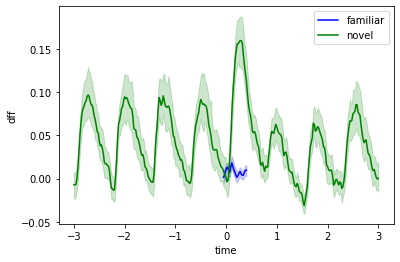

In [21]:
sns.lineplot(
    data=etr_fam,
    x='time',
    y='dff',
    n_boot=200,
    color='blue',
    label='familiar'
)
sns.lineplot(
    data=etr_nov,
    x='time',
    y='dff',
    n_boot=200,
    color='green',
    label='novel'
)